In [3]:
%matplotlib inline

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from matplotlib import style
from pandas_datareader import data
import random
from SALib.sample import latin
from functions.stylizedfacts import *
import scipy.stats as stats
from functions.evolutionaryalgo import *
from pandas_datareader import data
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns
import numpy as np
import json

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
style.use('ggplot')

# Fundamentals decoupled in an agent-based model: exploring trend-following and mean-reversion chartism

By **Joeri Schasfoort**

This is the notebook which belongs to the paper of the same name. That paper contributes to the debate about market efficiency by presenting a behavioural agent-based model which suggests that market prices might be decoupled from fundamentals for longer periods than previously thought. This decoupling is explained by an increased prevalence of technical or chartist trading. In the chartist and fundamentalist model framework, the model distinguishes between trend-following and a mean-reversion chartist trading. Replacing fundamentalist trading with the latter causes stock-market prices to become decoupled from their fundamental value. Because, just like fundamentalist trading, mean-reversion trading prevents excessive long-term price predictability as a consequence of trend-following, an increase of meanreversion trading at the expense of fundamentalist trading does not diminish the models ability to reproduce the stylized facts of stock market returns: no autocorrelation, volatility clustering, long memory, and fat tails.

The notebook allows for the replication of the main results and graphs of the paper. The results the notebook generals will differ slightly from those in the paper as those where computed using a larger amount of simulations on a cluster computer. 

The notebook is similar but not identical in structure to the paper. First, it present the model logic in Python code. Then, it shows how to download the data and calculate the stylized facts. After that, Morris methods are used to determine the sensitivity to input parameters. The notebook then shows how to estimate the model, simulate its estimated baseline dynamics, compare its performance to a model version without mean-reversion, and perform experiments switching between fundamentalist and mean-reversion trading. 

## The model

In [2]:
def sim_fin_model(traders, orderbook, parameters, seed=1):
    """
    The main model function
    :param traders: list of Agent objects
    :param orderbook: object Order book
    :param parameters: dictionary of parameters
    :param seed: integer seed to initialise the random number generators
    :return: list of simulated Agent objects, object simulated Order book
    """
    random.seed(seed)
    np.random.seed(seed)
    fundamental = [parameters["fundamental_value"]]

    for tick in range(parameters['horizon_max'] + 1, parameters["ticks"]):
        # evolve the fundamental value via random walk process
        fundamental.append(fundamental[-1] + parameters["std_fundamental"] * np.random.randn())

        # select random sample of active traders
        active_traders = random.sample(traders, int((parameters['trader_sample_size'])))

        # update common expectation components
        mid_price = orderbook.tick_close_price[-1]
        fundamental_component = np.log(fundamental[-1] / mid_price)
        chartist_component = np.cumsum(orderbook.returns[-parameters['horizon_max']:]
                                       ) / np.arange(1., float(parameters['horizon_max'] + 1))

        for trader in active_traders:
            # update trader specific expectations
            noise_component = parameters['std_noise'] * np.random.randn()

            fcast_return = trader.var.forecast_adjust * (
                trader.var.weight_fundamentalist * fundamental_component +
                trader.var.weight_chartist * chartist_component[trader.par.horizon] +
                trader.var.weight_random * noise_component -
                trader.var.weight_mean_reversion * chartist_component[trader.par.horizon])

            fcast_price = mid_price * np.exp(fcast_return)

            # submit orders
            if fcast_price > mid_price:
                bid_price = fcast_price * (1. - trader.par.spread)
                orderbook.add_bid(bid_price, abs(int(np.random.normal(scale=parameters['std_vol']))), trader)
            elif fcast_price < mid_price:
                ask_price = fcast_price * (1 + trader.par.spread)
                orderbook.add_ask(ask_price, abs(int(np.random.normal(scale=parameters['std_vol']))), trader)

        # match orders in the order-book
        while True:
            matched_orders = orderbook.match_orders()
            if matched_orders is None:
                break

        # clear and update order-book history
        orderbook.cleanse_book()
        orderbook.fundamental = fundamental

    return traders, orderbook

## The data

I collect data from three sources. First, I collect daily data on nominal prices from the S&P500 starting on the 1st of August 2008 and ending on the 16th August 2018 (2509 observations) from the Federal Reserve of St. Louis database. Second, I collect historical data on monthly S&P 500 prices and dividends from Robert Shiller’s database2 (Shiller, 2000). Third, I extract historical data on annual shortterm interest rates from the macro history database3 (Jordà et al., 2017). Table 1 presents the descriptive statistics of this data.

In [5]:
start_date = '2008-01-01'
end_date = '2018-08-16'

spy_nom_price = data.DataReader("SP500", 
                       start=start_date, 
                       end=end_date, 
                       data_source='fred')["SP500"].dropna()
spy_nom_returns = spy_nom_price.pct_change()[1:]

shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
schul_data = pd.read_excel('http://www.macrohistory.net/JST/JSTmoneyR3.xlsx', sheetname='Data')[['year', 'country', 'stir']]
schul_data = schul_data.loc[(schul_data.country == 'USA')]
schul_data = schul_data.iloc[1:]
schul_data = schul_data.set_index('year')

In [36]:
all_data = pd.DataFrame()
all_data['spy_nom'] = spy_nom_price.describe()
all_data['spy_real'] = shiller_data['Price'].describe()
all_data['Dividend'] = shiller_data['Dividend'].describe()
all_data['T-bill'] = schul_data['stir'].describe()
all_data

,spy_nom,spy_real,Dividend,T-bill
count,2488.000000,1771.000000,1770.000000,146.000000
mean,1706.335619,516.589640,15.352034,4.088973
std,548.628324,556.283435,8.665989,2.927739
min,676.530000,68.218432,5.026852,0.090000
25%,1228.857500,171.559513,8.606258,1.890000
50%,1691.535000,255.369288,12.834290,3.510000
75%,2097.562500,619.107125,19.509188,5.417500
max,2872.870000,2836.528900,50.996020,16.390000


### The fundamental value

To be able to calculate the fundamental value, I extend the Schularick annual data to monthly data. 

In [6]:
schul_data['stir']

short_term_int = []
counter = -1
for idx in range(len(shiller_data)):
    if idx % 12 == 0:
        counter += 1
    try:
        short_term_int.append(schul_data['stir'].iloc[counter])
    except:
        pass

So that, I can calculate the discount rate $i_t + r$ for the NPV model. Where $i_t$ is the short-term interest rate time $t$ while $r$ represents the equity price premium which is assumed to be constant at 5.2 which is the level of the equity risk premium estimated by [Avdis & Wachter (2017)](https://doi.org/10.1016/j.jfineco.2017.06.003).

In [7]:
discount_rates = np.array(short_term_int) + 5.2
discount_rates = pd.Series(discount_rates).apply(div_by_hundred)

And the discounted cash flows:

In [8]:
# long_int = shiller_data['Rate GS10'].apply(div_by_hundred) # is this nescessary? 
# current_index = 0
# final_index = len(shiller_data['Dividend'])
# discounted_cash_flows = shiller_data['Dividend'] / ((1 + long_int)**range(current_index, final_index))

This allows me to calculate the fundamental value. I combine the Shiller and macro history datasets to calculate the fundamental value using the fixed equity premium net present value model. It states that the fundamental value is the sum of discounted future dividend rates

\begin{equation}
F_{t} = \sum_{t=1}^{\kappa} \frac{D_t}{(1 + i_t + r)^{t+1}},
\end{equation}

where $D_t$ is the dividend. I set the horizon over which to discount future dividends $\kappa$ to the point at which $\frac{D_t}{(1 + i_t + e)^t} < 0.01$. Using this equation, I calculate the ex-post fundamental value of the S\&P 500 in which I assume the annual interest rate holds for all months in that particular year.

In [9]:
fundamental_values = []
for idx, cf in enumerate(shiller_data['Dividend'][:-18]):
    next_period_divs = shiller_data['Dividend'][idx+1:]
    next_period_ints = discount_rates[idx+1]
    npv = calculate_npv(next_period_divs, next_period_ints)
    if not np.isnan(npv):
        fundamental_values.append(npv)
    else:
        break

In [10]:
real_prices = shiller_data['Price'][:len(fundamental_values)]

This leads to the following plot found in the introduction of the paper: 

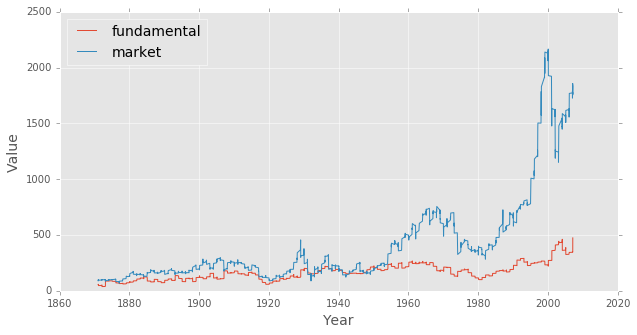

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

time=0

ax1.plot(shiller_data['Date'][time:len(fundamental_values)], fundamental_values[time:], label='fundamental')
ax1.plot(shiller_data['Date'][time:len(fundamental_values)], shiller_data['Price'][time:len(fundamental_values)], label='market')

ax1.set_ylabel('Value', fontsize='14')
ax1.set_xlabel('Year', fontsize='14')

ax1.legend(fontsize='14', loc='best')
fig.savefig('shiller_campbell_sp500.png')

### Bootstrapped data & moments

I calculate several moments which are associated with the stylized facts of financial markets and which captures the sustained deviation from the fundamental value.
 
To measure the (un)predictability of returns, I calculate the average autocorrelation over 25 lags and over the first and fifth lag. The average autocorrelation of absolute returns over 25 lags represents volatility clustering. Representing excess volatility, or fat tails in the returns, I measure excess kurtosis. To take into account long memory, I measure the autocorrelation of absolute returns at lag 10, 25, 50 and 100. Finally, as a measure of sustained deviations from fundamentals, I measure the co-integration of the price and the fundamental value using the augmented Engel-Granger test.

To facilitate the estimation of model parameters, I perform a block bootstrap on the data from which I extract the confidence intervals of the moments. To do so reliably, I make a distinction between moments which are recorded over different time lengths and perform three separate bootstrap procedures. 

For the block bootstrap procedure, I follow the approach set out by [Franke and Westerhoff (2012)](https://doi.org/10.1016/j.jedc.2011.10.004). That means that I divide the original data into blocks of size $b$. Then, randomly sampling from these blocks without replacement, I create 5000 unique new time series. To increase the diversity of simulated data, ideally, the block sizes are small. However, to capture some of the longer term moments, I use longer block sizes. 

For returns, I calculate the moments related to the predictability, volatility clustering and fat tails using block size $b = 250$. Then, for the moments related to long memory, I perform the same procedure with block size $b = 625$. Finally, I create time series of the returns of the historical price and fundamental value for the co-integration moment with block size $b = 205$.

In [12]:
small_block_size = 250
large_block_size = 625
shiller_block_size = 205

In [13]:
small_data_blocks = []
for x in range(0, len(spy_nom_returns), small_block_size):
    small_data_blocks.append(list(spy_nom_returns[x:x+small_block_size]))
    
# draw 5000 random series
bootstrapped_small_series = []
for i in range(5000):
    sim_data = [random.choice(small_data_blocks) for _ in small_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_small_series.append(sim_data2)
    
large_data_blocks = []
for x in range(0, len(spy_nom_returns), large_block_size): # used to be len(spy_nom_returns[:-250])
    large_data_blocks.append(list(spy_nom_returns[x:x+large_block_size]))
    
# draw 5000 random series
bootstrapped_long_series = []
for i in range(5000):
    sim_data = [random.choice(large_data_blocks) for _ in large_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_long_series.append(sim_data2)

For the deviation from fundamentals, I first bootstrap the returns of both the fundamental value and the associated returns for market prices. I divided these into blocks. Then, I bootstrap these blocks of returns into new time series and apply them to the starting values of the fundamental value and real prices. This results in 5000 hypothetical time series of fundamentals and real prices. 

In [14]:
fundamental_returns = pd.Series(fundamental_values).pct_change()[1:]
real_prices_returns = pd.Series(real_prices).pct_change()[1:]

In [15]:
# divide both fundamental returns and price returns into blocks
shiller_data_blocks = []
for x in range(0, len(fundamental_returns[:-3]), shiller_block_size):
    shiller_data_blocks.append((list(fundamental_returns[x:x+shiller_block_size]), list(real_prices_returns[x:x+shiller_block_size])))

In [17]:
def hypothetical_series(starting_value, returns):
    """
    input: starting_value: float starting value
    input: returns: list 
    """
    returns = list(returns)
    simulated_series = [starting_value]
    for idx in range(len(returns)):
        simulated_series.append(simulated_series[-1] * (1 + returns[idx]))
    return simulated_series

In [18]:
# draw 5000 random series 
bootstrapped_shiller_series = []
for i in range(5000):
    #print(i)
    # first sample the data
    sim_data = [random.choice(shiller_data_blocks) for _ in shiller_data_blocks] # choose a random set of blocks
    sim_data_fundamental_returns = [pair[0] for pair in sim_data]
    sim_data_price_returns = [pair[1] for pair in sim_data]
    
    # merge the list of lists
    sim_data_fundamental_returns1 = [item for sublist in sim_data_fundamental_returns for item in sublist]
    sim_data_price_returns1 = [item for sublist in sim_data_price_returns for item in sublist]
    
    # calculate the new time_series
    sim_data_fundamentals = hypothetical_series(fundamental_values[0], sim_data_fundamental_returns1)
    sim_data_prices = hypothetical_series(real_prices[0], sim_data_price_returns1)
    
    bootstrapped_shiller_series.append((sim_data_fundamentals, sim_data_prices))

For returns, I use the following moments short-term moments: 

1. mean first-order autocorrelation of the raw returns (no predictability),
2. autocorrelations at lags t ¼ 1
3. autocorrelations at lags t ¼ 5
4. mean first-order autocorrelation of the of the absolute returns (volatility clustering),
5. Kurtosis (fat tails), 

In [19]:
first_order_autocors = []
mean_abs_autocor = []
autocors1 = []
autocors5 = []
kurtoses = []
for rets in bootstrapped_small_series:
    first_order_autocors.append(autocorrelation_returns(rets, 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(rets, 25))
    rets = pd.Series(rets)
    autocors1.append(rets.autocorr(lag=1))
    autocors5.append(rets.autocorr(lag=5))
    kurtoses.append(kurtosis(rets))

For long-term moments, I use the autocorrelation of returns for the with lags (10, 25, 50, 100).

In [20]:
spy_abs_auto10 = []
spy_abs_auto25 = []
spy_abs_auto50 = []
spy_abs_auto100 = []

for rets in bootstrapped_long_series:
    rets = pd.Series(rets)
    spy_abs_auto10.append(rets.abs().autocorr(lag=10))
    spy_abs_auto25.append(rets.abs().autocorr(lag=25))
    spy_abs_auto50.append(rets.abs().autocorr(lag=50))
    spy_abs_auto100.append(rets.abs().autocorr(lag=100))

For deviations from fundamentals, I use the AFD t-score to test for mean-reversion in the relationship between fundamentals and the price.

In [22]:
cointegrations = []

for sers in bootstrapped_shiller_series:
    cointegrations.append(cointegr(sers[0], sers[1])[0])